evaluate existing predictions to see how well they do

# Plan to Build the Model
0. Pull all coin data every day
    - Set up cron job on domains or creativity account to run script every day and output results
    - Maybe set up an automated email so I don't have to go searching for the data
    - Data can be stored on a server and can be analyzed after it is pulled, with a final report sent to me and Max
1. Feature engineering
    - Create features from the price data based on investor intuition to see what is helpful
        - Various lags inside the FDW
        - Rolling mean, min, max, etc. statistics
        - Bollinger bands and statistics
        - Rolling entropy, or rolling majority, for categorical features
        - Rolling text statistics for text features
    - Time features
    - Lag features
    - Rolling window features (pick the last month, calculate summary statistics)
    - Expanding window statistics (all of the data, calculate summary statistics)
    - Automated feature engineering using TSFresh or some other package
2. Build the model
    - Predict for the following time windows: 1 day, 3 day, 7 day, 14 day, 1 month, 3 month, 6 month, 1 year, 3 year, 5 year
    - Could build model using regression
    - I could try using various strategies (support vector regression, GLM, XG Boost)
    - Could use generalized linear model including currency name (and maybe day or week timestamp) as random factors
    - Building a model like this will let us easily add weekly twitter, gitub, and machinery variables (might inflate p-values)
    - Also try using classification models using up 20% and down 10% as outcomes
    - Support Vector Machines works well in high dimensional spaces
3. See how good the model is at predicting cumulative price increases over time
    - Use cross validation (training set and test set) to see which variables are best
    - Use a validation set to see how well the final model works in the real world
    - Could split up data based on coins (put different coins in different groups)
    - I'll need to match coins based on volatility and current price to make sure we have equivalent groups in train/test

# Get all coins available through the cryptocompare API

In [61]:
#this needs to run everyday first to check what new coins are available and check which coins have been deprecated
%matplotlib inline
import requests as r
import pandas as pd
import numpy as np
import re

response = r.get('https://www.cryptocompare.com/api/data/coinlist/')
print(response)
data = response.json()

coins = pd.DataFrame.from_dict(data['Data'],'index')
coins['SortOrder'] = coins['SortOrder'].astype(int)
coins = coins.sort_values('SortOrder')

try:
    coins_old = pd.read_csv('C:/Users/bodil/Projects/Crypto/coins/coins.csv')
except:
    temp = pd.DataFrame(columns=['Name','SortOrder'])
    temp.to_csv('C:/Users/bodil/Projects/Crypto/coins/coins.csv',index=False)
    coins_old = pd.read_csv('C:/Users/bodil/Projects/Crypto/coins/coins.csv')

coins_old = coins_old.sort_values('SortOrder')

new_coin_names = set(coins.Name.astype(str)) - set(coins_old.Name.astype(str))
no_longer_available = set(coins_old.Name.astype(str)) - set(coins.Name.astype(str))

if no_longer_available != no_longer_available:
    no_longer_available = ''

new_coin_names_df = pd.DataFrame(list(new_coin_names),columns=['Name'])
no_longer_available_df = pd.DataFrame(list(no_longer_available),columns=['Name'])

new_coin_names_df.to_csv('C:/Users/bodil/Projects/Crypto/coins/new_coin_names.csv', index=False, encoding='utf-8')
no_longer_available_df.to_csv('C:/Users/bodil/Projects/Crypto/coins/no_longer_available.csv', index=False, encoding='utf-8')

#save all coin information into the coins CSV
coins.to_csv('C:/Users/bodil/Projects/Crypto/coins/coins.csv', index=False, encoding='utf-8')

<Response [200]>


#  
# Get historical price data for a coin
#  

In [62]:
def fix_data(data):
    new_list = []
    for x in data['Data']:
        new_list.append({
            'time':x['time'],
            'high':x['high'],
            'low':x['low'],
            'open':x['open'],
            'volumefrom':float(x['volumefrom']),
            'volumeto':x['volumeto'],
            'close':x['close'],
        })
    return new_list

In [64]:
#gets historical prices for new coins. Runs every single day (keeping up on new coins added or removed)
import os
import requests as r
import re
from datetime import datetime

date = str(datetime.now().date())

new_coins = pd.read_csv('C:/Users/bodil/Projects/Crypto/coins/new_coin_names.csv', encoding='utf-8')
coins_to_pull_historical = new_coins.Name.values

# coins_to_pull_historical = list(get_historical)

all_price_data = pd.read_csv('C:/Users/bodil/Projects/Crypto/all_price_data.csv')

coin_dicts = []
for coin in coins_to_pull_historical:
    if coin not in already_done:
        response = r.get('https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym=USD&limit=1000&aggregate=1'.format(coin))
        data = response.json()
        try:
            df = pd.DataFrame(data['Data'])
        except:
            df = pd.DataFrame(fix_data(data))
        df['coin'] = coin
        all_price_data = all_price_data.append(df)

all_price_data.drop_duplicates(inplace=True)
all_price_data.to_csv('C:/Users/bodil/Projects/Crypto/all_price_data.csv',encoding='utf-8',index=False)

NameError: name 'already_done' is not defined

In [96]:
#gets daily prices for all coins. Runs every single day.
import os
import requests as r
import re

coins = pd.read_csv('C:/Users/bodil/Projects/Crypto/coins/coins.csv', encoding='utf-8')
coins_to_pull_daily = coins.Name.values

all_price_data = pd.read_csv('C:/Users/bodil/Projects/Crypto/all_price_data.csv')

coin_dicts = []
for coin in coins_to_pull_daily:
    response = r.get('https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym=USD&limit=1&aggregate=1'.format(coin))
    data = response.json()
    try:
        df = pd.DataFrame(data['Data'])
    except:
        df = pd.DataFrame(fix_data(data))
    df['coin'] = coin
    try:
        all_price_data = all_price_data.append(df.loc[1])
    except:
        try:
            all_price_data = all_price_data.append(df.loc[0])
        except:
            pass

all_price_data.drop_duplicates(inplace=True)
all_price_data.sort_values(['coin','time'],inplace=True)
all_price_data.to_csv('C:/Users/bodil/Projects/Crypto/all_price_data.csv',encoding='utf-8',index=False)

# Feature engineering

In [22]:
from datetime import datetime,timedelta
import pandas as pd
df = pd.read_csv('C:/Users/bodil/Projects/Crypto/all_price_data.csv')

In [54]:
df.coin.unique()[30:40]

array(['ADCN', 'ADL', 'ADN', 'ADST', 'ADT', 'ADX', 'ADZ', 'AE', 'AEC',
       'AEON'], dtype=object)

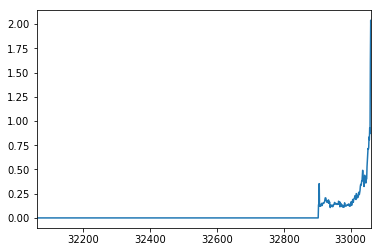

In [60]:
df[df.coin == 'ADST'].close.plot()

In [13]:
df['timestamp'] = df['time'].map(lambda x: datetime.utcfromtimestamp(x))

In [14]:
df['change_day'] = df.open - df.close

In [15]:
###handle infinity values
df['percent_change'] = df.change_day / df.open

In [16]:
df['volatility'] = (df.high - df.low) / df.open

In [17]:
#percent of no change
df['percent_change'].value_counts()[0] / df['percent_change'].count()

0.48418442258972921

In [18]:
df['up'] = df.change_day.map(lambda x: 1 if x > 0 else 0)

In [19]:
df['down'] = df.change_day.map(lambda x: 1 if x < 0 else 0)

In [20]:
df['pct_change_1_day'] = df.percent_change.rolling(min_periods=1, window=1).sum().shift(-1)
df['pct_change_3_day'] = df.percent_change.rolling(min_periods=1, window=3).sum().shift(-3)
df['pct_change_7_day'] = df.percent_change.rolling(min_periods=1, window=7).sum().shift(-7)

In [21]:
for y in [1,3,7]:
    for x in [.10,.20,.30]:
        df['up_by_{}_{}_day'.format(x,y)] = df['pct_change_{}_day'.format(y)].map(lambda y: 1 if y >= x else 0)

In [123]:
for y in [1,3,7]:
    for x in [-.10,-.20,-.30]:
        df['down_by_{}_{}_day'.format(x,y)] = df['pct_change_{}_day'.format(y)].map(lambda y: 1 if y <= x else 0)

ValueError: range parameter must be finite.

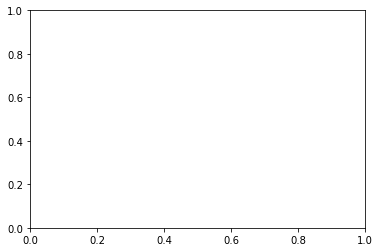

In [124]:
df['percent_change'].hist(bins=100)

In [34]:
from matplotlib import pyplot as plt

In [35]:
(df.close + abs(df.close.min()) + 1).min()

1.00012246

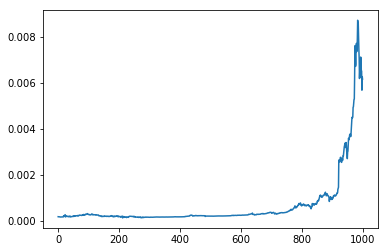

In [36]:
import numpy as np
plt.plot(np.log(df.close + abs(df.close.min()) + 1))

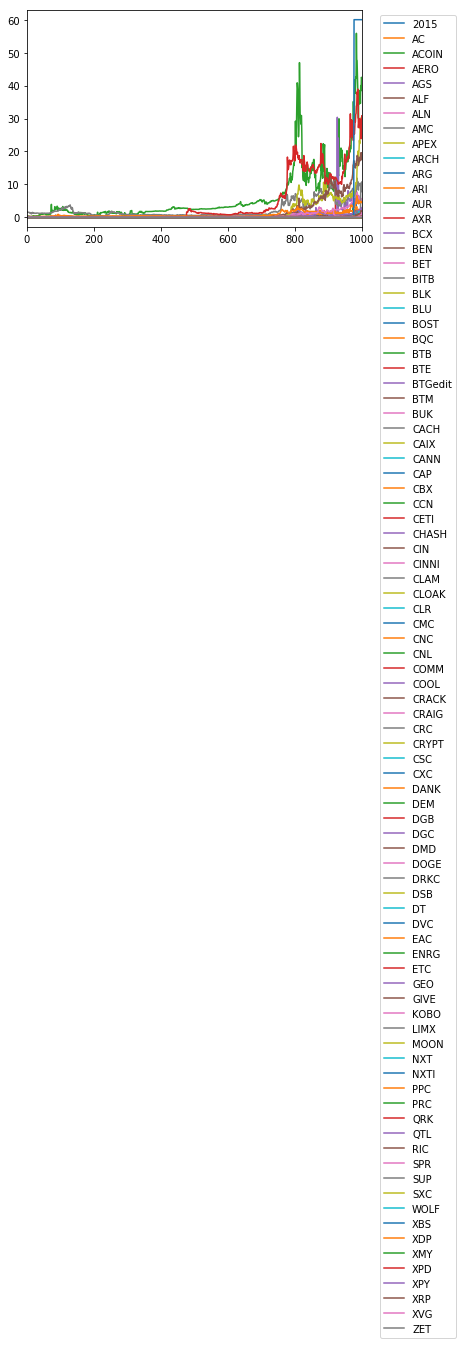

In [142]:
#line graph of daily prices for top one hundred coins
base_file_name = 'C:/Users/bodil/Projects/Crypto/coin_data/'
for filename in os.listdir(base_file_name):
    
    coin = filename.split('.')[0]
    
    #these are huge greater than 10000 coins
    if coin in ['42','BTC','YBC']:
        continue
    
    #these are marginally big greater than 2000 coins
    if coin in ['BTS','CASH','ZEC']:
        continue
    
    #these are greater than 600
    if coin in ['DASH','ETH']:
        continue
        
    #these are greater than 100:
    if coin in ['BTCD','LTC','XMR']:
        continue
    #import data
    try:
        df = pd.read_csv(base_file_name + filename)
    except:
        continue
    ax = df.rename(columns={'close':coin})[coin].plot()
    if df['close'].max() > 100:
        print(coin)
    ax.legend(bbox_to_anchor=(1.04,1))

In [37]:
#a look at the top ten coins
top_ten_coins

array(['BTC', 'ETH', 'LTC', 'DASH', 'XMR', 'NXT', 'ETC', 'DOGE', 'ZEC',
       'BTS'], dtype=object)

In [96]:
#look at individual line charts for each coin in the top ten
import pandas as pd
df = pd.DataFrame(coin_dicts[0]['data']['Data'])
print(coin_dicts[0]['coin_name'])

BTC


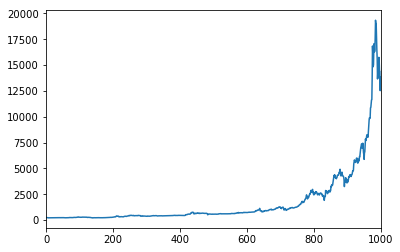

In [93]:
%matplotlib inline
df.close.plot()